In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sequence_jacobian import simple, create_model
from sequence_jacobian.utilities.drawdag import drawdag
from fredapi import Fred

# Question 1

### Part 1

In [2]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')
start_date = '1947-01-01'

In [ ]:
## TO DO: create function to return logged data series

In [3]:
## SERIES UP TO 2019Q4
end_date = '2019-10-01'

Y_trunc = fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)
Y_log_trunc = np.log(fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)) * 100

# deflator for consumption series
defl_trunc = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

# convert nominal consumption series to real
C_log_trunc = np.log(fred.get_series('PCEC', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100
Cd_log_trunc = np.log(fred.get_series('PCDG', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100
Cn_log_trunc = np.log(fred.get_series('PCND', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100

I_log_trunc = np.log(fred.get_series('GPDIC1', observation_start = start_date, observation_end = end_date)) * 100
G_log_trunc = np.log(fred.get_series('GCEC1', observation_start = start_date, observation_end = end_date)) * 100

# total hours = weekly hours * employment
H_trunc = fred.get_series('PRS85006023', observation_start = start_date, observation_end = end_date)
E_trunc = fred.get_series('PAYEMS', observation_start = start_date, observation_end = end_date)
E_trunc = E_trunc[0:(len(E_trunc) + 1):3]
E_log_trunc = np.log(E_trunc) * 100
N_log_trunc = np.log(H_trunc * E_trunc) * 100

YN_log_trunc = np.log(Y_trunc / H_trunc) * 100

# convert nominal wages to real
w_log_trunc = np.log(fred.get_series('COMPNFB', observation_start = start_date, observation_end = end_date) / defl_trunc) * 100

# real interest rate = federal funds rate - realized inflation
ffr_trunc = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = end_date)
ffr_trunc = ffr_trunc[0:(len(ffr_trunc) + 1):3]
r_trunc = ffr_trunc - (np.diff(np.log(defl_trunc)) * 100)[29:]

In [4]:
## SERIES UP TO 2022Q4
end_date = '2022-10-01'

Y = fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)
Y_log = np.log(fred.get_series('GDPC1', observation_start = start_date, observation_end = end_date)) * 100

# deflator for consumption series
defl = fred.get_series('PCECTPI', observation_start = start_date, observation_end = end_date)

# convert nominal consumption series to real
C_log = np.log(fred.get_series('PCEC', observation_start = start_date, observation_end = end_date) / defl) * 100
Cd_log = np.log(fred.get_series('PCDG', observation_start = start_date, observation_end = end_date) / defl) * 100
Cn_log = np.log(fred.get_series('PCND', observation_start = start_date, observation_end = end_date) / defl) * 100

I_log = np.log(fred.get_series('GPDIC1', observation_start = start_date, observation_end = end_date)) * 100
G_log = np.log(fred.get_series('GCEC1', observation_start = start_date, observation_end = end_date)) * 100

# total hours = weekly hours * employment
H = fred.get_series('PRS85006023', observation_start = start_date, observation_end = end_date)
E = fred.get_series('PAYEMS', observation_start = start_date, observation_end = end_date)
E = E[0:(len(E) + 1):3]
E_log = np.log(E) * 100
N_log = np.log(H * E) * 100

YN_log = np.log(Y / H) * 100

# convert nominal wages to real
w_log = np.log(fred.get_series('COMPNFB', observation_start = start_date, observation_end = end_date) / defl) * 100

# real interest rate = federal funds rate - realized inflation
ffr = fred.get_series('FEDFUNDS', observation_start = start_date, observation_end = end_date)
ffr = ffr[0:(len(ffr) + 1):3]
r = ffr - (np.diff(np.log(defl)) * 100)[29:]

# Question 2

### Part 1

In [17]:
@simple
def firm(K, n, a, alpha, delta):
    r = alpha * a * (K(-1) / n) ** (alpha-1) - delta
    w = (1 - alpha) * a * (K(-1) / n) ** alpha
    Y = a * K(-1) ** alpha * n ** (1 - alpha)
    return r, w, Y

@simple
def household(K, n, w, eis, frisch, b, delta):
    C = (w / b / n ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, n, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * n
    return goods_mkt, euler, walras

In [18]:
rbc = create_model([household, firm, mkt_clearing], name="rbc_problem_2")

In [19]:
# according to Cedomir, remove a and r from calibration - DON'T FOLLOW THE SECTION CODE
# calibration: known parameter values
# unknowns: K, n, unknown paramenter values (b, beta, delta)
# targets: Euler equation, market-clearing condition, K/Y = 14, I/Y = 0.25, n = 1/3

calibration = {"n": 1./3., "eis": 0.5, "frisch": 1., "delta": 0.0178, "alpha": 0.33}
unknowns_ss = {"b": 8.766, "beta": 0.994, "K": 17.12, "a": 1.}
targets_ss = {"goods_mkt": 0., "r": 0.024, "euler": 0., "Y": 1.222}

ss = rbc.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")

In [7]:
print(f"Goods market clearing: {ss['goods_mkt']},\nEuler equation: {ss['euler']},\nWalras: {ss['walras']}")

Goods market clearing: 0.0,
Euler equation: 7.771561172376096e-16,
Walras: -1.4432899320127035e-15


In [8]:
unknowns = ['K', 'n']
targets = ['euler', 'goods_mkt']
inputs = ['a']

G = rbc.solve_jacobian(ss, unknowns, targets, inputs, T=200)

In [9]:
T, impact, rho = 200, 0.01, 0.9
da = np.zeros((T, 2))
da[0, 0] = impact * ss['a']
da[:, 1] = impact * ss['a'] * rho**np.arange(T)

In [10]:
var_list = ["Y", "n", "C", "I", "K", "w", "r"]

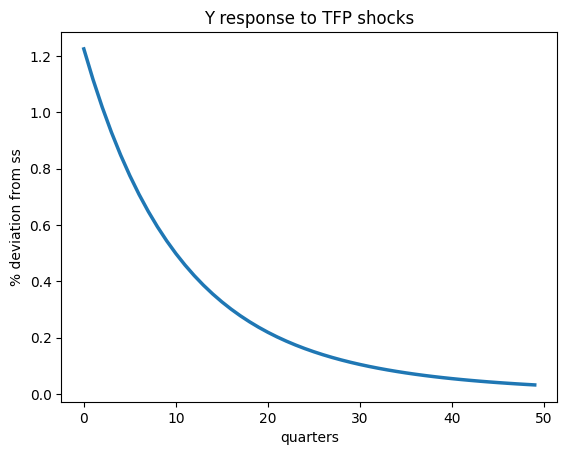

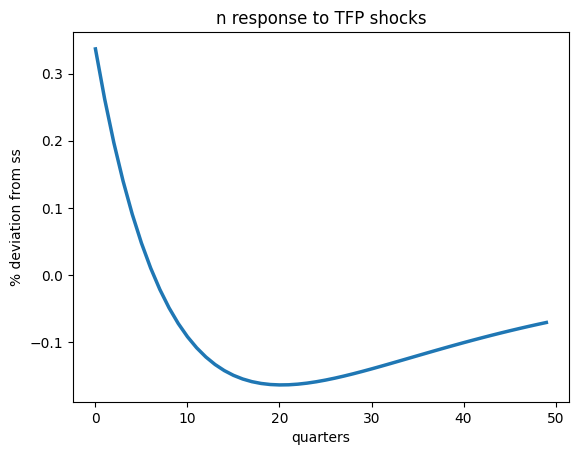

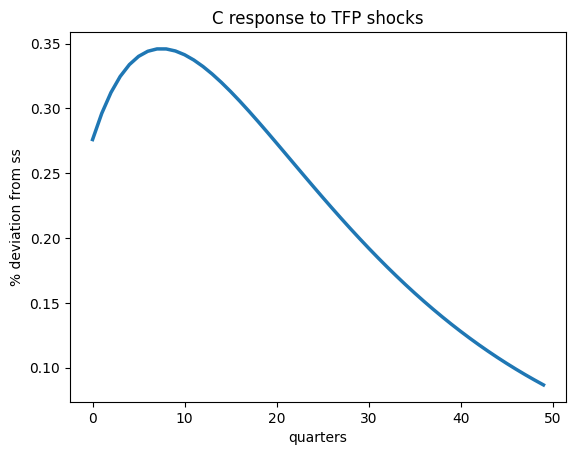

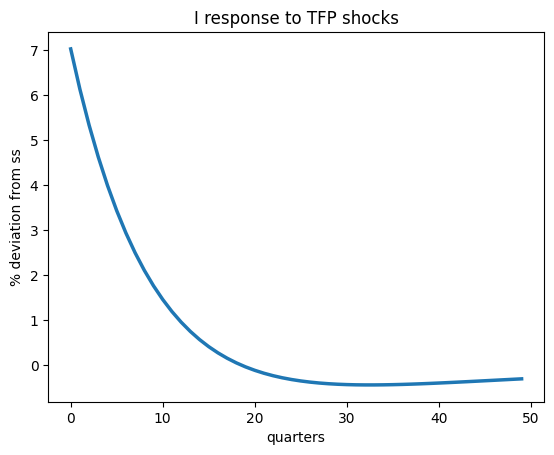

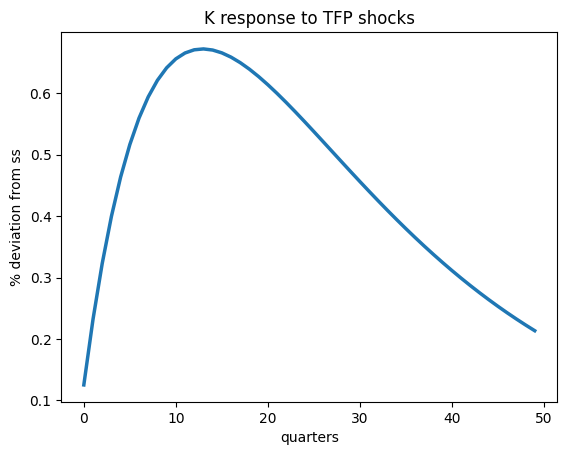

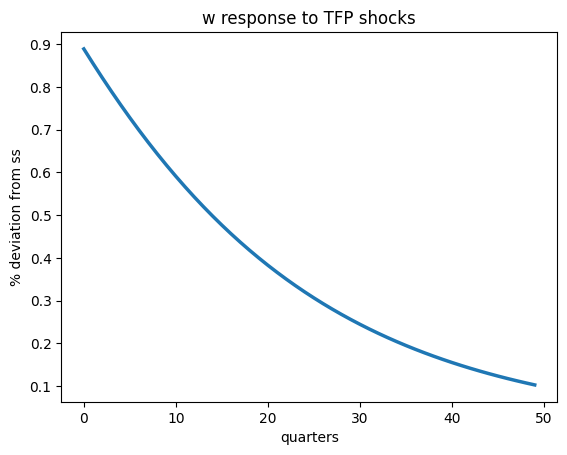

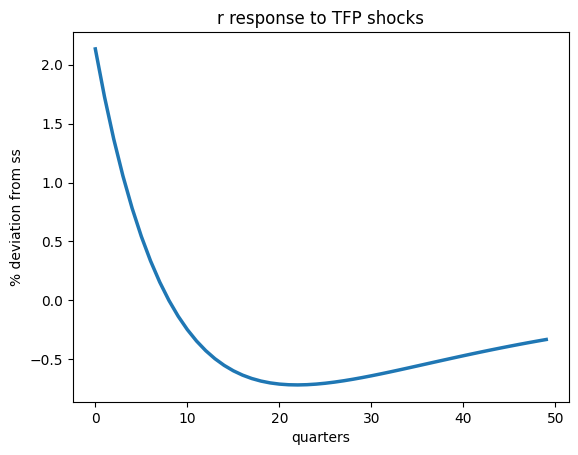

In [11]:
for var in var_list:
    dVal = 100 * G[var]['a'] @ da / ss[var]
    plt.plot(dVal[:50, 1], linewidth=2.5)
    plt.title(f'{var} response to TFP shocks')
    plt.ylabel('% deviation from ss')
    plt.xlabel('quarters')
    plt.show()

### Part 2

First, let us construct a class to hold information about each simulation

In [ ]:
import math
PERIODS = 200
BURN = 50
IMPACT = impact
RHO = rho

class Economy():
    def __init__(self, g_matrix, steady_state):
        # Get impulse response matrix and steady state from toolbox
        self.g_matrix = g_matrix 
        self.steady_state = steady_state

        # Create a list of iid shocks
        self.epsilon_list = np.random.normal(0, IMPACT, PERIODS + BURN)
        self.burned_epsilons = self.epsilon_list[BURN:]

        # Generate list of as given epsilons
        self.a_list = self.convert_epsilons_to_as(self.epsilon_list)
        self.burned_as = self.a_list[BURN:]

        # Generate a list of das given as
        # Note: da_list[0] = None because there is no lag for period 0
        self.da_list = [None] + [self.a_list[i] - self.a_list[i-1] for i in range(1, PERIODS + BURN)]
        self.burned_das = self.da_list[BURN:]

        # Generate sequences for capital, consumption, output, and labor
        self.K_list = self.simulate_sequence('K')
        self.burned_Ks = self.K_list[BURN:]

        self.C_list = self.simulate_sequence('C')
        self.burned_Cs = self.C_list[BURN:]

        self.Y_list = self.simulate_sequence('Y')
        self.burned_Ys = self.Y_list[BURN:]

        self.n_list = self.simulate_sequence('n')
        self.burned_ns = self.n_list[BURN:]

        self.w_list = self.simulate_sequence('w')
        self.burned_ws = self.w_list[BURN:]

        self.r_list = self.simulate_sequence('r')
        self.burned_rs = self.r_list[BURN:]

        self.I_list = self.simulate_sequence('I')
        self.burned_Is = self.I_list[BURN:]

    def convert_epsilons_to_as(self, epsilon_list):
        """
        Given a sequence of iid normal shocks, generates an AR(1) process
        representing log of a. 
        """
        lna_list = np.zeros(PERIODS + BURN)
        lna_list[0] = self.steady_state['a']
        for i in range(1, PERIODS + BURN):
            lna_list[i] = lna_list[i-1] * RHO + epsilon_list[i]
        return [math.exp(lna) for lna in lna_list]
    
    def simulate_sequence(self, variable):
        """
        Given a variable, generates a sequence of values for that variable
        """
        sequence = np.zeros(PERIODS + BURN)
        sequence[0] = self.steady_state[variable]
        for i in range(1, PERIODS + BURN):
            sequence[i] = sequence[i-1] + self.g_matrix[variable]['a'][i-1] * self.da_list[i]
        return sequence
    
    # Now we do getters for the burned sequences
    def get_burned_Ks(self):
        return self.burned_Ks
    
    def get_burned_Cs(self):
        return self.burned_Cs
    
    def get_burned_Ys(self):
        return self.burned_Ys
    
    def get_burned_ns(self):
        return self.burned_ns
    
    def get_burned_as(self):
        return self.burned_as
    
    def get_burned_das(self):
        return self.burned_das
    
    def get_burned_epsilons(self):
        return self.burned_epsilons
    
    def get_burned_ws(self):
        return self.burned_ws
    
    def get_burned_rs(self):
        return self.burned_rs
    
    def get_burned_Is(self):
        return self.burned_Is
    
Economy(G, ss)

Now that we have our simulation class defined, we can generate 100 of them as desired

In [ ]:
simulations = []
for i in range(100):
    e = Economy(G, ss)
    simulations.append(e)